In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from tqdm import tqdm
# import tensorflow as tf
import random
import shutil
plt.style.use('default')
plt.ioff()
import keras #Deep learning library using Tensorflow backend

#Needed neural network layer types
from keras.models import Sequential
from keras.layers import Dense, Dropout, Normalization
from keras.preprocessing.image import ImageDataGenerator

#Graph loss vs accuracy over epochs
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import ModelCheckpoint

#Pretrained Networks
from keras.applications.resnet import ResNet50

from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
# train = tf.keras.utils.image_dataset_from_directory('train', labels="inferred", label_mode="int",image_size=(96, 128,))
test = tf.keras.utils.image_dataset_from_directory('test', labels="inferred", label_mode="int",image_size=(96, 128,),shuffle=False)

strategy = tf.distribute.MirroredStrategy(
     cross_device_ops=tf.distribute.ReductionToOneDevice())

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

In [ ]:
#CHANGE RUN NAME EACH TIME
run_name = 'resnet50train20k100e'
folder = f'cnnRuns/{run_name}'
if not os.path.exists(folder):
    os.mkdir(folder)
else:
    print('Directory already exists')

In [ ]:
#Load model, get truth labels, prediction probablities for class 1, and test dataset
model = keras.models.load_model(f'cnnRuns/{run_name}.keras')
proba = model.predict(test)
pred = np.argmax(proba,1)
proba = list(zip(*proba))[1]
truth = np.concatenate([y for x,y in test])
test_list = list(test)

In [ ]:
#write train and test set images names to .txt files
train_imgs = os.listdir('train/signal')+os.listdir('train/background')
train_imgs = [img+',\n' for img in train_imgs]
test_imgs = os.listdir('test/signal')+os.listdir('test/background')
test_imgs = [img+',\n' for img in test_imgs]

f = open(os.path.join(folder,'train_imgs.txt'),'w')
f.writelines(train_imgs)
f.close()

f = open(os.path.join(folder,'test_imgs.txt'),'w')
f.writelines(test_imgs)
f.close()

In [ ]:
#plot and save ROC curve
fpr,tpr,t = roc_curve(truth,proba)
auc = np.round(roc_auc_score(truth,proba),2)
plt.plot(fpr,tpr)
model_name = run_name.split('train')[0]
title = f'ROC Curve {model_name} | AUC score: {auc}'
plt.title(title)
plt.ylabel('TPR'); plt.xlabel('FPR')
plt.savefig(f'{folder}/ROC{run_name}.png')
plt.clf()

In [ ]:
#plot and save confusion matrix
cm = confusion_matrix(truth, pred, labels=[1,0],)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Signal','Background'])
disp.plot()
plt.tight_layout()
plt.savefig(f'{folder}/CM{run_name}.png')
plt.clf()

In [ ]:
#plot and save training data samples
plt.figure(figsize=(15,10))
directory = 'train/signal'
# directory = 'highF_injSignal'
for i in range(30):
    plt.subplot(5,6,i+1)
    ind = np.random.randint(0,len(os.listdir(directory)))
    imgDir = (os.path.join(directory,os.listdir(directory)[ind]))
    img = plt.imread(imgDir)
    plt.imshow(img,)
    plt.axis('off')
    plt.title("".join(imgDir.split('train/')[-1]),fontsize=10)

plt.tight_layout()
plt.savefig(f'{folder}/TrainingSignals_{run_name}.pdf')
plt.clf()

plt.figure(figsize=(15,10))
directory = 'train/background'
# directory = 'highF_noSignal'
for i in range(30):
    plt.subplot(5,6,i+1)
    ind = np.random.randint(0,len(os.listdir(directory)))
    imgDir = (os.path.join(directory,os.listdir(directory)[ind]))
    img = plt.imread(imgDir)
    plt.imshow(img,)
    plt.axis('off')
    plt.title("".join(imgDir.split('train/')[-1]), fontsize=10)
    
plt.tight_layout()
plt.savefig(f'{folder}/TrainingBackground_{run_name}.pdf')
plt.clf()

In [ ]:
def ceildiv(a, b):
...     return -(a // -b)

In [ ]:
#plot and save incorrect predictions. Fig size may need changing depending on num incorrect samples
false_inds = [(i//32, i%32, i) for i,result in enumerate(truth==pred) if result==False]
fig = plt.figure(figsize=(10,30)) #(10,50)
false_preds = [test_list[i][0][j] for i,j,k in false_inds]
for i in range(len(false_preds)):
    plt.subplot(ceildiv(len(false_preds),5),5,i+1)
    plt.imshow(false_preds[i]/255)
    plt.title(f'Truth: {truth[false_inds[i][2]]}, Pred: {pred[false_inds[i][2]]}',fontsize=10)
    plt.axis('off')
plt.tight_layout()
# plt.suptitle('Incorrect Predictions')
plt.savefig(f'{folder}/IncorectPredictions_{run_name}.pdf')
# plt.show()

In [ ]:
true_inds = [(i//32, i%32, i) for i,result in enumerate(truth==pred) if result==True]
true_inds = np.array(true_inds)[random.sample(range(len(true_inds)),100)]
fig = plt.figure(figsize=(10,30)) #(10,50)
true_preds = [test_list[i][0][j] for i,j,k in true_inds]
for i in range(len(true_preds)):
    plt.subplot(20,5,i+1)
    plt.imshow(true_preds[i]/255)
    plt.title(f'Truth: {truth[true_inds[i][2]]}, Pred: {pred[true_inds[i][2]]}',fontsize=10)
    plt.axis('off')
plt.tight_layout()
# plt.suptitle('Incorrect Predictions')
plt.savefig(f'{folder}/CorectPredictions_{run_name}.pdf')
# plt.show()

In [ ]:

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.layers[1].input], [model.layers[1].get_layer(last_conv_layer_name).output, model.layers[1].output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

import matplotlib.cm as cm

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    # img = keras.preprocessing.image.load_img(img_path)
    # img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = np.array(jet_heatmap) * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    return plt.imread(cam_path)

decode_predictions = keras.applications.resnet.decode_predictions
last_conv_layer_name = "conv5_block3_out"

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
# img_array = np.reshape(false_preds[0],(1,96,128, 3))
# preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
# plt.matshow(heatmap)
# plt.show()


In [ ]:
#plot and save grad cams of incorrect predictions. Fig size may need changing depending on num incorrect samples
grad_cams = [save_and_display_gradcam(false_preds[i],make_gradcam_heatmap(np.reshape(false_preds[i],(1,96,128,3)), model, last_conv_layer_name)) for i in range(len(false_preds))]
fig = plt.figure(figsize=(10,30))
for i in range(len(false_preds)):
    plt.subplot(17,5,i+1)
    plt.imshow(grad_cams[i])
    plt.title(f'Truth: {truth[false_inds[i][2]]}, Pred: {pred[false_inds[i][2]]}',fontsize=10)
    plt.axis('off')
plt.tight_layout()
# fig.suptitle('Incorrect Predictions GRAD-CAM')
# plt.show()
plt.savefig(f'{folder}/IncorectPredictionsGradCam_{run_name}.pdf')

In [ ]:
#plot and save grad cams of incorrect predictions. Fig size may need changing depending on num incorrect samples
grad_cams = [save_and_display_gradcam(true_preds[i],make_gradcam_heatmap(np.reshape(true_preds[i],(1,96,128,3)), model, last_conv_layer_name)) for i in range(len(true_preds))]
fig = plt.figure(figsize=(10,30))
for i in range(len(true_preds)):
    plt.subplot(20,5,i+1)
    plt.imshow(grad_cams[i])
    plt.title(f'Truth: {truth[true_inds[i][2]]}, Pred: {pred[true_inds[i][2]]}',fontsize=10)
    plt.axis('off')
plt.tight_layout()
# fig.suptitle('Incorrect Predictions GRAD-CAM')
# plt.show()
plt.savefig(f'{folder}/CorectPredictionsGradCam_{run_name}.pdf')

In [ ]:
plt.figure(figsize=(15,10))
# directory = 'train/signal'
directory = 'highF_injSignal'
for i in range(25):
    plt.subplot(5,5,i+1)
    ind = np.random.randint(0,len(os.listdir(directory)))
    imgDir = (os.path.join(directory,os.listdir(directory)[ind]))
    img = plt.imread(imgDir)
    plt.imshow(img,)
    plt.axis('off')
    # plt.tight_layout()
    plt.title("".join(imgDir.split('train/')[-1]),fontsize=10)
plt.show()

plt.figure(figsize=(15,10))
# directory = 'train/background'
directory = 'highF_noSignal'
for i in range(25):
    plt.subplot(5,5,i+1)
    ind = np.random.randint(0,len(os.listdir(directory)))
    imgDir = (os.path.join(directory,os.listdir(directory)[ind]))
    img = plt.imread(imgDir)
    plt.imshow(img,)
    plt.axis('off')
    # plt.tight_layout()
    plt.title("".join(imgDir.split('train/')[-1]), fontsize=10)
plt.show()

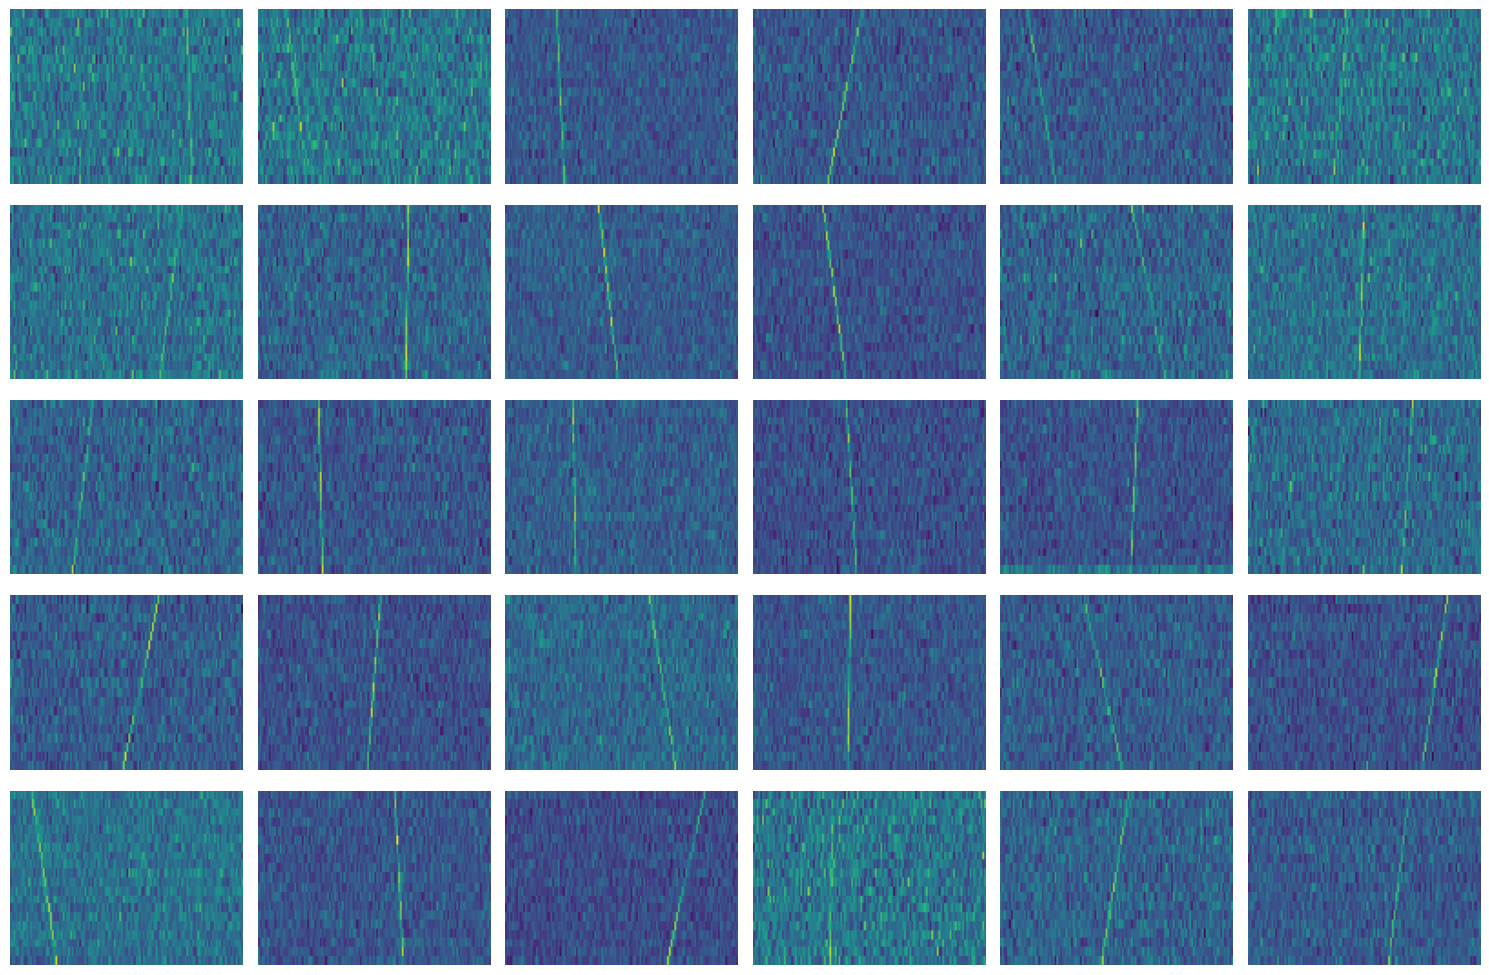

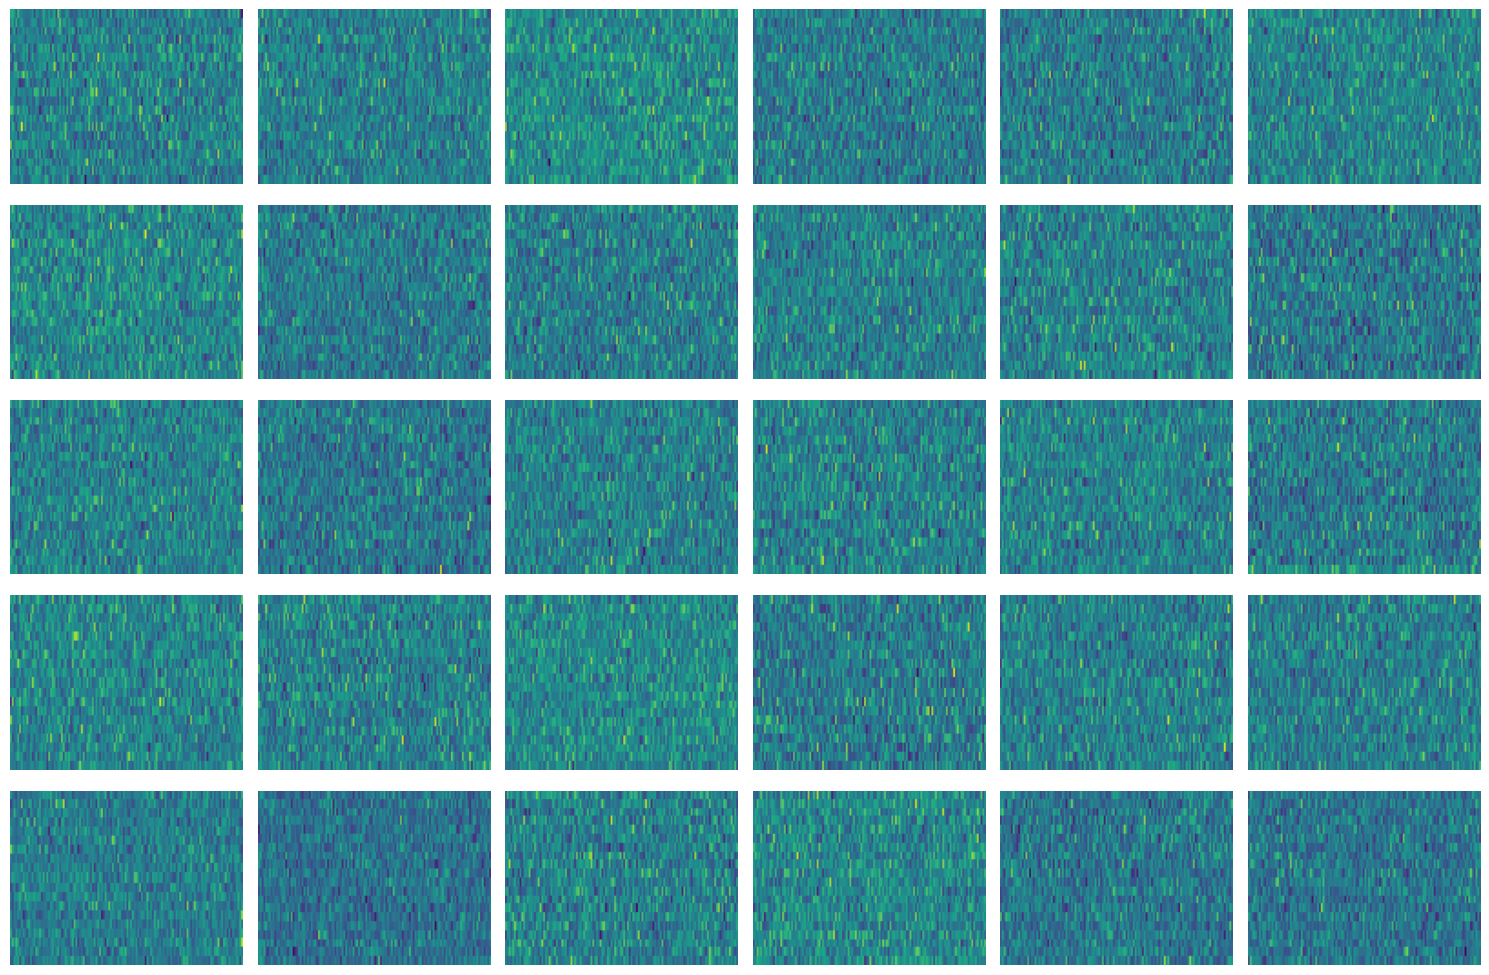